# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [38]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/olavdc/miniforge3/envs/linearSCVI/lib/python3.10/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [39]:
import sys
sys.path.append('/home/olavdc/github/multVI_experiments/scvi_tools/src')

In [40]:
import os

import matplotlib.pyplot as plt
import scanpy as sc
import scvi_local
import anndata
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
from pathlib import Path

In [41]:
sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

# Load data

In [44]:
adata = sc.read_h5ad("/home/olavdc/github/linearSCVI_experiments/data/ac0c6561-7a48-4185-af6f-af799f699172.h5ad")

In [ ]:
adata

In [45]:
adata_subset = adata[(adata.obs.disease == "Alzheimer disease") | (adata.obs.disease == "normal")]

In [48]:
adata_subset.layers["counts"] = adata_subset.X.copy()  # preserve counts
sc.pp.normalize_total(adata_subset, target_sum=10e4)
sc.pp.log1p(adata_subset)
adata_subset.raw = adata_subset  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata_subset, flavor="seurat_v3", layer="counts", n_top_genes= 1000, subset=True
)

scvi_local.model.LinearSCVI.setup_anndata(adata_subset, layer="counts")

/tmp/ipykernel_2720/294076773.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X.copy()  # preserve counts


## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [49]:
# Load the autoreload extension
%load_ext autoreload

# Enable automatic reloading of module
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# setup the anndata for scvi-tools
scvi_local.model.LinearSCVI.setup_anndata(adata_subset, layer="counts")

Save model

In [ ]:
# import wandb
# import torch

# run_name = wandb.run.name 
# filename = f"model_weights_{run_name}.pth"
# PATH = (f"/home/olavdc/github/linearSCVI_experiments/checkpoints/{filename}")
# model.save(PATH)

Load Z & W

In [ ]:
adata = sc.read_h5ad("/home/olavdc/github/linearSCVI_experiments/data/ac0c6561-7a48-4185-af6f-af799f699172.h5ad")
adata_subset = adata[(adata.obs.disease == "Alzheimer disease") | (adata.obs.disease == "normal")]

# pre-processing
adata_subset.layers["counts"] = adata_subset.X.copy()  # preserve counts
sc.pp.normalize_total(adata_subset, target_sum=10e4)
sc.pp.log1p(adata_subset)
adata_subset.raw = adata_subset  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata_subset, flavor="seurat_v3", layer="counts", n_top_genes= 1000, subset=True
)

scvi_local.model.LinearSCVI.setup_anndata(adata_subset, layer="counts")

/tmp/ipykernel_2637/3568498831.py:5: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata_subset.layers["counts"] = adata_subset.X.copy()  # preserve counts


In [ ]:
n_latent = 20 
# initialize LinearSCVI model
model = scvi_local.model.LinearSCVI(
    adata_subset,
    use_batch_norm=False,
    gene_likelihood = "nb",
    n_latent=n_latent)

In [ ]:
model = model.load("/home/olavdc/github/linearSCVI_experiments/checkpoints/model_weights_rare-plant-21", adata= adata_subset)

INFO     File /home/olavdc/github/linearSCVI_experiments/checkpoints/model_weights_rare-plant-21/model.pt already  
         downloaded                                                                                                


Inspecting the convergence

In [ ]:
adata_subset.var.index = adata_subset.var.feature_name

In [ ]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata_subset.obs[f"Z_{i}"] = z
Z_df = pd.DataFrame(Z_hat, adata_subset.obs.index)
Z_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
4419,0.126602,-0.214195,0.308146,-0.483276,0.751462,0.013620,0.205587,-0.270398,0.815894,1.533783,-0.292215,0.425281,0.685210,0.322135,1.175097,0.375509,-1.168018,-0.524916,-0.777411,0.537176
4420,-0.049861,-0.426364,1.600901,0.677356,-0.254145,-0.911771,1.112305,-0.361371,1.522517,-0.354481,0.433573,-0.739912,0.889536,-0.117452,-0.523255,0.470589,-1.383194,-0.459689,-0.432585,0.069826
4421,0.812159,-0.877378,-0.127854,0.089203,0.078402,-0.273524,0.300425,-0.695641,1.097709,-0.198007,-0.030723,-0.123041,0.509855,0.364658,0.130514,0.207128,-0.550177,-0.616917,-0.469357,0.126974
4422,0.714393,-0.944241,-0.984222,0.632467,-0.926143,0.529234,-0.009385,-0.007752,1.732589,-0.454811,1.253940,-1.147947,0.047696,0.375331,0.506379,0.903154,-1.098833,-1.250131,-0.404889,-0.794701
4423,0.508883,-0.554899,0.054134,-0.155139,-0.041597,-0.179002,0.175886,-0.407761,1.233587,-0.142034,0.221811,-0.038429,0.362628,0.440965,-0.188641,0.073714,-0.268710,-0.323340,-0.540721,-0.256844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429638,1.144725,-0.806381,0.600165,-0.407194,-0.174874,-1.005656,-0.828372,-1.403431,1.092506,0.148341,0.362652,0.112599,0.052604,1.447507,-0.957118,0.916718,0.559733,-0.670759,0.131882,0.195429
429639,0.316439,0.251075,-0.224670,0.953160,0.146751,-0.682472,0.422153,-0.676828,2.122911,-0.520629,-0.552577,0.389034,0.299848,-0.658667,-0.204850,-0.022928,-0.822611,-0.544032,-0.278000,-0.997207
429640,0.026323,-1.763548,0.055087,-0.367333,1.735411,0.274201,-0.430788,-0.551940,0.749383,-0.401924,0.825511,-0.031211,0.834414,-0.586424,-0.946002,0.262371,0.020043,1.134895,-1.101476,-0.469523
429641,0.872526,-0.061976,-0.130008,-0.429459,1.444782,0.123956,-0.110216,0.200702,1.505603,0.267783,-0.253348,-1.610778,-0.373746,1.377276,-0.555556,0.447175,-0.102979,-0.910772,-0.056902,-0.107319


In [ ]:
W_df = model.get_loadings()
W_df.index = adata_subset.var.index
W_df

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9,Z_10,Z_11,Z_12,Z_13,Z_14,Z_15,Z_16,Z_17,Z_18,Z_19
feature_name,,,,,,,,,,,,,,,,,,,,
PRDM16,-0.131578,0.017288,-0.080341,-0.280814,0.054230,-0.042159,-0.263292,0.302296,-0.912023,0.763479,-0.288088,0.271469,-0.083091,-0.377532,0.222713,0.084277,-0.228906,-0.373872,0.060716,0.247933
TNFRSF1B,-0.153749,0.015062,-0.174695,-0.016217,0.539054,0.625411,-0.047172,-0.220288,-1.593497,-0.752389,0.643171,0.546878,0.527662,-0.248915,0.083094,-0.669645,0.558441,0.621945,-0.359969,0.098803
SRARP,0.802221,0.124817,-0.516924,-0.248554,-0.560701,1.002232,0.624352,-0.002325,-2.267151,-0.959476,-0.456479,0.155691,-0.094544,-0.210392,-0.411684,-0.674738,-0.170392,-0.474212,-0.074433,0.074200
ID3,0.882443,0.250422,0.047157,-0.001871,0.098507,0.481822,0.546589,-0.435757,-1.704764,0.076093,-0.521255,0.359790,0.106422,-0.091191,0.353738,0.517082,-0.645088,-0.661399,-0.464534,0.268301
EPB41,0.287027,0.076175,-0.162811,-0.105067,0.272809,-0.300277,-0.165120,-0.265149,0.465177,-0.065001,0.471639,0.132196,0.523188,-0.460986,-0.332779,0.267029,-0.089699,0.354979,-0.018273,0.358581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGC4859,0.351923,0.355667,0.112266,-0.160340,-0.233311,-0.156076,0.277538,-0.056656,-0.263461,-0.302060,-0.252758,0.017212,-0.326777,-0.301280,-0.460300,0.283245,0.559960,-0.118159,-0.034788,-0.505909
ENSG00000283982.1,-0.119634,-0.041509,-0.048327,0.839203,-0.564285,0.439907,0.178687,0.526428,-0.222919,-0.642551,0.029171,-0.257410,-0.372792,-0.413563,-0.508894,0.182111,0.655991,0.511366,-0.580382,-0.091360
ENSG00000284418.3,0.182245,-0.264617,-0.252252,0.592417,-0.663467,0.372101,0.012880,0.623112,-0.780797,-0.438015,0.474030,-0.141273,-0.500622,-0.312127,0.040203,0.246878,0.497774,0.477186,0.042624,-0.675085


In [ ]:
# Z_df = pd.read_csv("Z_df.csv" , index_col=0)
# W_df = pd.read_csv("W_df.csv", index_col=0)

In [ ]:
Z_df = Z_df.add_prefix('z')
# W_df = W_df.add_prefix('z')

In [ ]:
def Z_covariance(Z):
    Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [ ]:
_, variance_explained = Z_covariance(Z_df)
idx = np.argsort(variance_explained)[::-1]

In [ ]:
variance_explained

array([0.09780083, 0.07865994, 0.0669941 , 0.01195199, 0.06330845,
       0.02999391, 0.05735843, 0.05651327, 0.05386325, 0.03563753,
       0.0362716 , 0.0382339 , 0.04041799, 0.05184118, 0.0509106 ,
       0.04345507, 0.04506709, 0.04553199, 0.04749608, 0.04869281])

In [ ]:
Z_df_ordered = pd.DataFrame(Z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = Z_df.index
W_df_ordered = pd.DataFrame(W_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = W_df.index

In [ ]:
text_shift = {
    (0, 'Fst'): (0.2, -0.2),
    (0, 'Pmp22'): (-0.1, -0.3),
    (0, 'Hoxaas3'): (0.0, 0.3),
    (0, 'Acta2'): (0.0, 0.2),
    (0, 'Nnat'): (0.0, 0.5),
    (0, 'Ifitm1'): (0.0, 0.2),
    
    (1, 'Srgn'): (0., -0.2),
    (1, 'Amn'): (-0.7, 0.),
    
    (2, 'Crabp2'): (0.0, 0.4),
    (2, 'Tdgf1'): (0.0, 0.4),
    (2, 'Cer1'): (-0.6, 0.0),
    (2, 'T'): (-1.3, 0.0),
    
    (3, 'Cdx1'): (0.0, 0.4),
    (3, 'Cdx2'): (-1.0, 0.7),
    (3, 'Cited1'): (-1.6, -0.0),
    (3, 'Phlda2'): (-0.7, 0.0),
    (3, 'T'): (0.0, 0.2),
    (3, 'Ifitm1'): (-0.2, 0.0),
#     (3, 'Rspo2'): (-0.3, 0.0),
#     (3, 'Htr2c'): (0.6, 0.1),
#     (3, 'Col1a1'): (0.0, 0.2),
    
#     (4, 'Ttn'): (0.0, -0.4),
#     (4, 'Sntb1'): (0.0, -0.3),
#     (4, 'Colec12'): (-1.1, 0.1),
#     (4, 'Adam12'): (0.1, 0.4),
#     (4, 'Spon1'): (0.0, 0.2),
#     (4, 'Gm3764'): (-0.2, 0.3),
#     (4, 'C130071C03Rik'): (1.5, -0.35),
    
}

In [ ]:
W_df_ordered["gene_name"] = W_df_ordered.index

In [ ]:
W_df_ordered

,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,...,w11,w12,w13,w14,w15,w16,w17,w18,w19,gene_name
feature_name,,,,,,,,,,,,,,,,,,,,,
PRDM16,-0.131578,0.017288,-0.080341,0.054230,-0.263292,0.302296,-0.912023,-0.377532,0.222713,0.247933,...,-0.373872,-0.228906,0.084277,-0.083091,0.271469,-0.288088,0.763479,-0.042159,-0.280814,PRDM16
TNFRSF1B,-0.153749,0.015062,-0.174695,0.539054,-0.047172,-0.220288,-1.593497,-0.248915,0.083094,0.098803,...,0.621945,0.558441,-0.669645,0.527662,0.546878,0.643171,-0.752389,0.625411,-0.016217,TNFRSF1B
SRARP,0.802221,0.124817,-0.516924,-0.560701,0.624352,-0.002325,-2.267151,-0.210392,-0.411684,0.074200,...,-0.474212,-0.170392,-0.674738,-0.094544,0.155691,-0.456479,-0.959476,1.002232,-0.248554,SRARP
ID3,0.882443,0.250422,0.047157,0.098507,0.546589,-0.435757,-1.704764,-0.091191,0.353738,0.268301,...,-0.661399,-0.645088,0.517082,0.106422,0.359790,-0.521255,0.076093,0.481822,-0.001871,ID3
EPB41,0.287027,0.076175,-0.162811,0.272809,-0.165120,-0.265149,0.465177,-0.460986,-0.332779,0.358581,...,0.354979,-0.089699,0.267029,0.523188,0.132196,0.471639,-0.065001,-0.300277,-0.105067,EPB41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MGC4859,0.351923,0.355667,0.112266,-0.233311,0.277538,-0.056656,-0.263461,-0.301280,-0.460300,-0.505909,...,-0.118159,0.559960,0.283245,-0.326777,0.017212,-0.252758,-0.302060,-0.156076,-0.160340,MGC4859
ENSG00000283982.1,-0.119634,-0.041509,-0.048327,-0.564285,0.178687,0.526428,-0.222919,-0.413563,-0.508894,-0.091360,...,0.511366,0.655991,0.182111,-0.372792,-0.257410,0.029171,-0.642551,0.439907,0.839203,ENSG00000283982.1
ENSG00000284418.3,0.182245,-0.264617,-0.252252,-0.663467,0.012880,0.623112,-0.780797,-0.312127,0.040203,-0.675085,...,0.477186,0.497774,0.246878,-0.500622,-0.141273,0.474030,-0.438015,0.372101,0.592417,ENSG00000284418.3


['LINC02552' 'ENSG00000236494.3' 'POSTN' 'CNGB1' 'LINC01687' 'THEMIS'
 'LINC01781' 'LINC00702']
['HBD' 'LINC01781' 'ALAS2' 'CRH' 'TRPM1' 'KRT16' 'ENSG00000253154.4'
 'EOMES']
['ENSG00000254361.2' 'CHRM5' 'TTR' 'LINC00348' 'ADAMTS18' 'LHX6' 'POSTN'
 'KRT16']
['CXCL10' 'CXCL11' 'LINC02972' 'DEFA3' 'LIF' 'CXCL3' 'ENSG00000236069.2'
 'TNF']
['ENSG00000236494.3' 'ENSG00000253154.4' 'CSN1S1' 'CCL3L3' 'IL1B' 'CXCL11'
 'IFNG-AS1' 'SV2C']
['HSPA6' 'CHRM5' 'ENSG00000236494.3' 'TAC3' 'AIF1' 'MS4A6A' 'SMOC1' 'ANO2']
['EOMES' 'RXFP2' 'LIF' 'MKI67' 'ENSG00000236494.3' 'RORB' 'CSN1S1'
 'ENSG00000251199.6']
['LAMA2' 'ADAMTS18' 'HAS2' 'SLC15A5' 'CCN4' 'COBLL1' 'ENSG00000253154.4'
 'LINC03000']
['TNF' 'CCL3' 'ENSG00000253503.6' 'LURAP1L-AS1' 'CHRM5' 'RGS1' 'LINC01170'
 'OLR1']
['ENSG00000250137.1' 'LINC01170' 'ENSG00000274441.1' 'CCL3L3' 'LINC02388'
 'STC1' 'CCL4' 'MARCO']


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

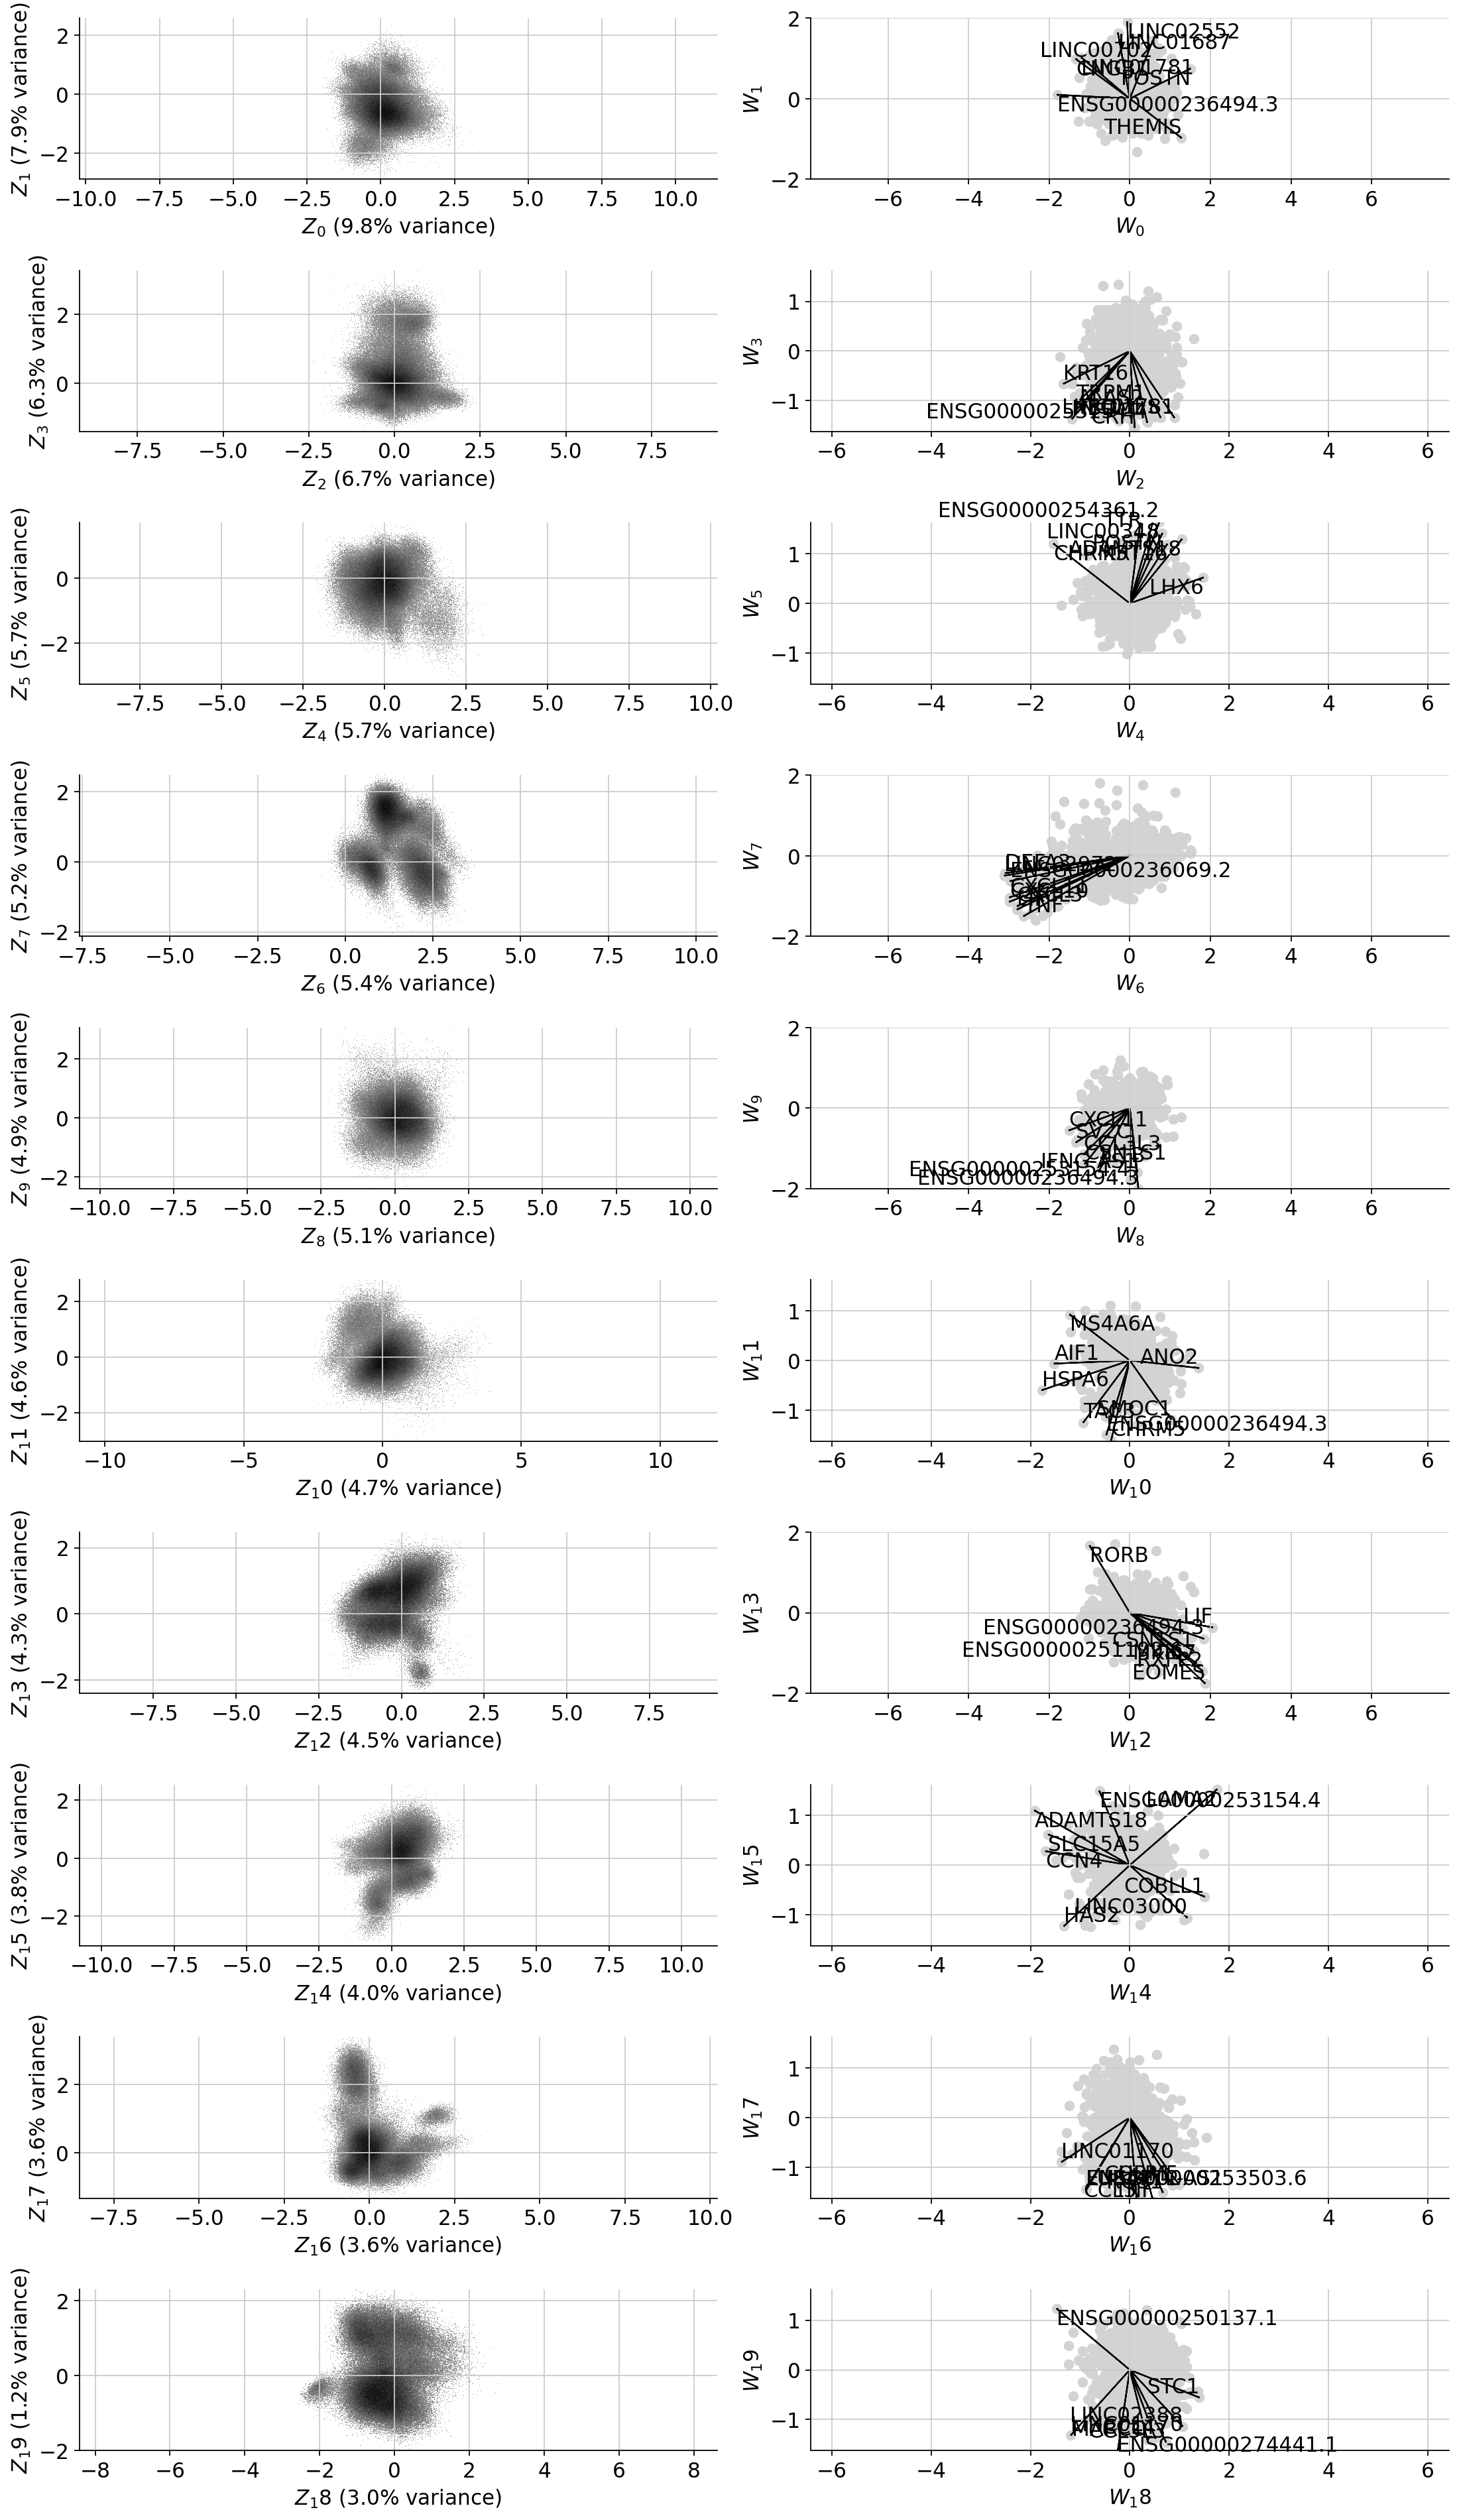

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Define figure size
plt.figure(figsize=(14, 24))

# Iterate for each plot
for i in range(10):
    
    # -- Z plot --
    plt.subplot(10, 2, 2 * i + 1)
    
    plt.hist2d(
        Z_df_ordered[f'z{2 * i}'], Z_df_ordered[f'z{2 * i + 1}'],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$Z_{2 * i}$ ({variance_explained[idx][2 * i]:.1%} variance)')
    plt.ylabel(f'$Z_{2 * i + 1}$ ({variance_explained[idx][2 * i + 1]:.1%} variance)')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # -- W plot --
    plt.subplot(10, 2, 2 * i + 2)
    
    w_columns = [f'w{2 * i}', f'w{2 * i + 1}']
    
    plt.scatter(
        W_df_ordered[w_columns[0]], W_df_ordered[w_columns[1]],
        c='lightgrey',
        rasterized=True
    )
    plt.axis('equal')
    plt.xlabel(f'$W_{2 * i}$')
    plt.ylabel(f'$W_{2 * i + 1}$')
    
    tmp_ = W_df_ordered.copy()
    tmp_['lnth'] = np.linalg.norm(tmp_[w_columns], axis=1)
    
    ggg = (
        tmp_
        .sort_values('lnth', ascending=False)
        .head(8)[['gene_name', 'lnth', *w_columns]]
    )
    print(ggg['gene_name'].values)
    
    texts = []
    arrows = []
    for g, r in ggg.iterrows():
        x_, y_ = r[w_columns[0]], r[w_columns[1]]
        
        ha = 'right' if x_ > 0 else 'left'
        va = 'top' if y_ > 0 else 'bottom'
        
        arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='black'))
        
        xs, ys = 0, 0
        if (i, r.gene_name) in text_shift:
            xs, ys = text_shift[(i, r.gene_name)]
        
        texts.append(plt.text(x_ + xs, y_ + ys, r.gene_name, ha=ha, va=va))

    plt.xlim(left=-2, right=2)
    plt.ylim(bottom=-2, top=2)
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust layout to fit plots
plt.tight_layout()

# Save figure as a PDF with high resolution
# plt.savefig('figures/linear_pij_results.pdf', bbox_inches='tight', dpi=400)


In [ ]:
metadata = adata_subset.obs.loc[Z_df_ordered.index]

In [ ]:
metadata = metadata.join(Z_df_ordered)

In [ ]:
for batch_condition in np.unique(metadata['disease']):
    z_corrs = Z_df_ordered.corrwith((metadata['disease'] == batch_condition))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head()
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], batch_condition)

[' z2: +0.21', 'z10: -0.18', ' z4: +0.17', 'z11: -0.16', ' z9: +0.14'] Alzheimer disease
[' z2: -0.21', 'z10: +0.18', ' z4: -0.17', 'z11: +0.16', ' z9: -0.14'] normal


In [ ]:
def make_kde(x1, x2):
    dx1 = (x1.max() - x1.min()) / 10
    dx2 = (x2.max() - x2.min()) / 10

    x1min = x1.min() - dx1
    x2min = x2.min() - dx2
    x1max = x1.max() + dx1
    x2max = x2.max() + dx2

    xx1, xx2 = np.mgrid[x1min:x1max:100j, x2min:x2max:100j]

    positions = np.vstack([xx1.ravel(), xx2.ravel()])
    values = np.vstack([x1, x2])

    kernel = stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx1.shape)
    
    return xx1, xx2, f

In [ ]:
from matplotlib import cm
from scipy import stats


In [ ]:
vardata = W_df_ordered

In [ ]:
latent_dim_1 = 'z19'
latent_dim_2 = 'z11'
weight_dim_1 = 'w19'
weight_dim_2 = 'w11'

In [ ]:
# latent_dims = []
# weight_dims = []
# for dim in range(n_latent):
#     latent_dims.append(f'z{dim}')
#     weight_dims.append(f'w{dim}')

In [ ]:
top_factors_list = []
for top_factor in top_factors.keys():
    top_factors_list.append(top_factor)

In [ ]:
from itertools import combinations

top_factor_pairs = list(combinations(top_factors_list,2))

In [ ]:
metadata

,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19
4419,54742156,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,astrocyte,CL:0000127,64-year-old stage,HsapDv:0000158,Alzheimer disease,MONDO:0004975,...,-0.777411,-0.524916,-1.168018,0.375509,0.685210,0.425281,-0.292215,1.533783,0.013620,-0.483276
4420,54742157,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,glutamatergic neuron,CL:0000679,64-year-old stage,HsapDv:0000158,Alzheimer disease,MONDO:0004975,...,-0.432585,-0.459689,-1.383194,0.470589,0.889536,-0.739912,0.433573,-0.354481,-0.911771,0.677356
4421,54742158,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,glutamatergic neuron,CL:0000679,64-year-old stage,HsapDv:0000158,Alzheimer disease,MONDO:0004975,...,-0.469357,-0.616917,-0.550177,0.207128,0.509855,-0.123041,-0.030723,-0.198007,-0.273524,0.089203
4422,54742159,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,glutamatergic neuron,CL:0000679,64-year-old stage,HsapDv:0000158,Alzheimer disease,MONDO:0004975,...,-0.404889,-1.250131,-1.098833,0.903154,0.047696,-1.147947,1.253940,-0.454811,0.529234,0.632467
4423,54742160,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,glutamatergic neuron,CL:0000679,64-year-old stage,HsapDv:0000158,Alzheimer disease,MONDO:0004975,...,-0.540721,-0.323340,-0.268710,0.073714,0.362628,-0.038429,0.221811,-0.142034,-0.179002,-0.155139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429638,55167375,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,oligodendrocyte,CL:0000128,60-79 year-old stage,HsapDv:0000272,Alzheimer disease,MONDO:0004975,...,0.131882,-0.670759,0.559733,0.916718,0.052604,0.112599,0.362652,0.148341,-1.005656,-0.407194
429639,55167376,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,glutamatergic neuron,CL:0000679,60-79 year-old stage,HsapDv:0000272,Alzheimer disease,MONDO:0004975,...,-0.278000,-0.544032,-0.822611,-0.022928,0.299848,0.389034,-0.552577,-0.520629,-0.682472,0.953160
429640,55167377,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,microglial cell,CL:0000129,60-79 year-old stage,HsapDv:0000272,Alzheimer disease,MONDO:0004975,...,-1.101476,1.134895,0.020043,0.262371,0.834414,-0.031211,0.825511,-0.401924,0.274201,-0.367333
429641,55167378,ac0c6561-7a48-4185-af6f-af799f699172,10x 3' v2,EFO:0009899,oligodendrocyte precursor cell,CL:0002453,60-79 year-old stage,HsapDv:0000272,Alzheimer disease,MONDO:0004975,...,-0.056902,-0.910772,-0.102979,0.447175,-0.373746,-1.610778,-0.253348,0.267783,0.123956,-0.429459


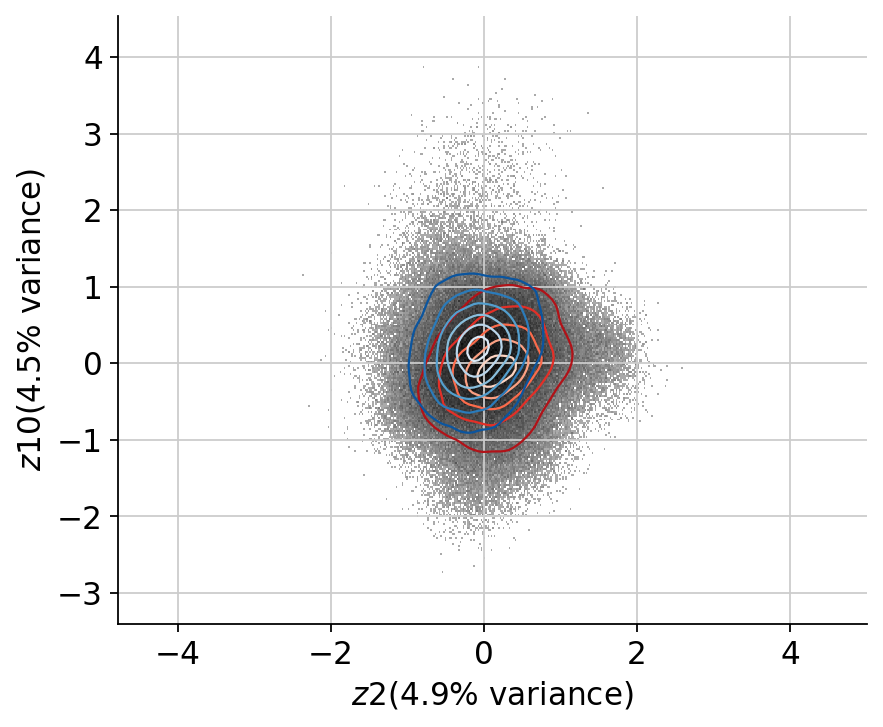

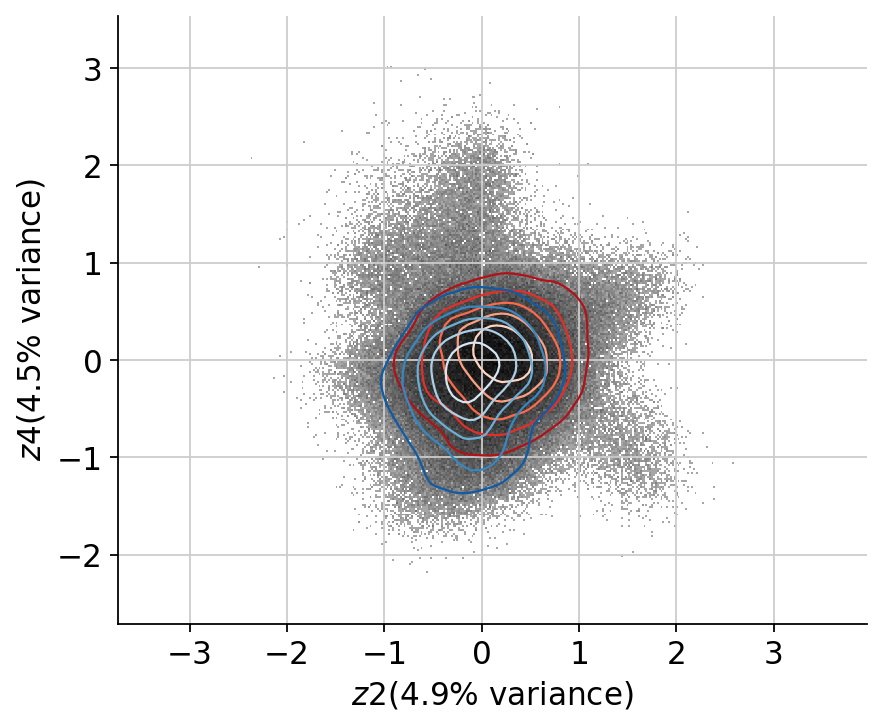

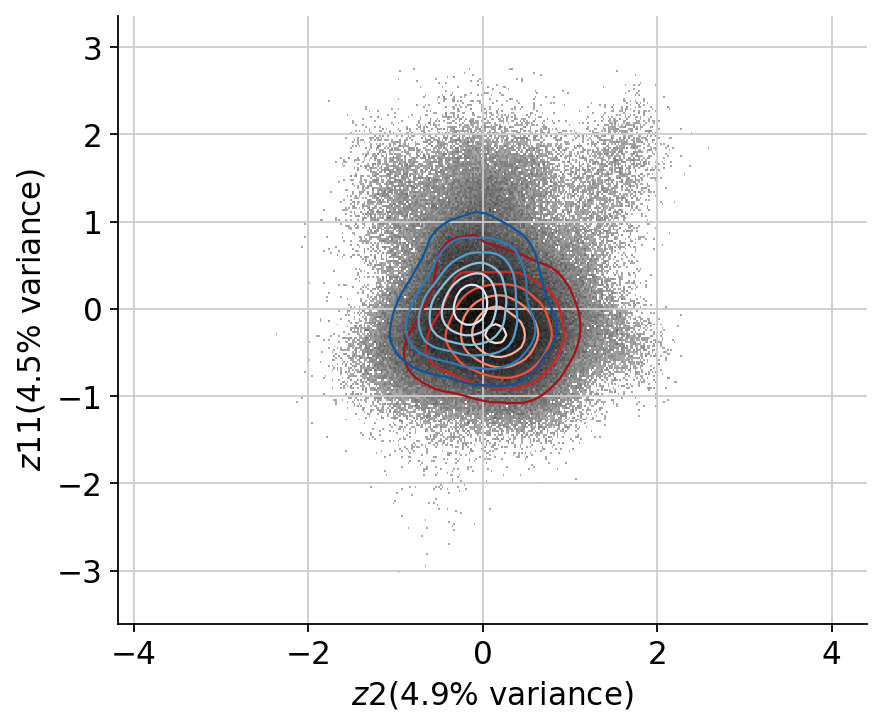

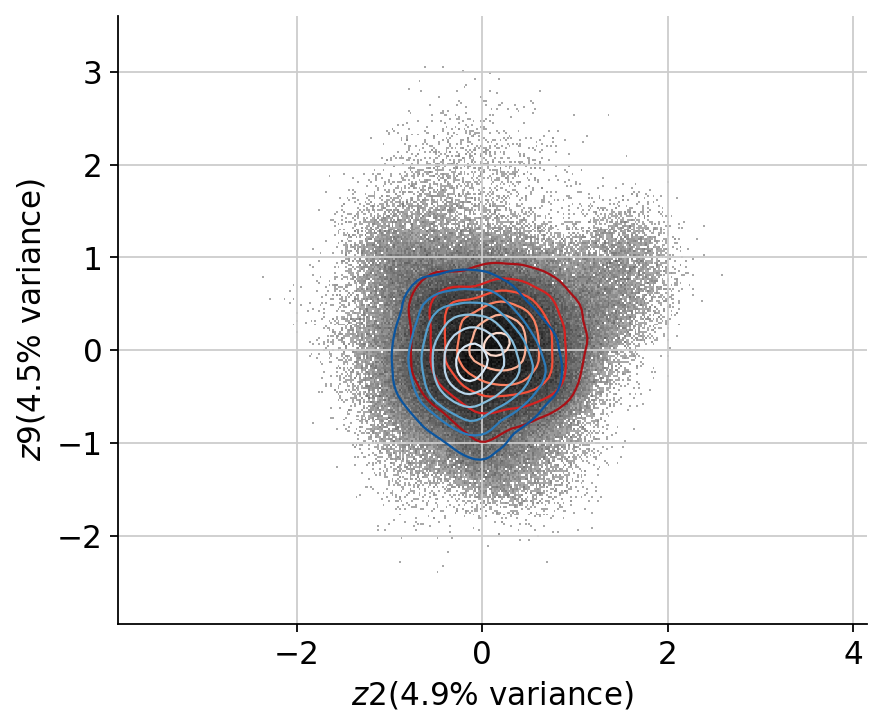

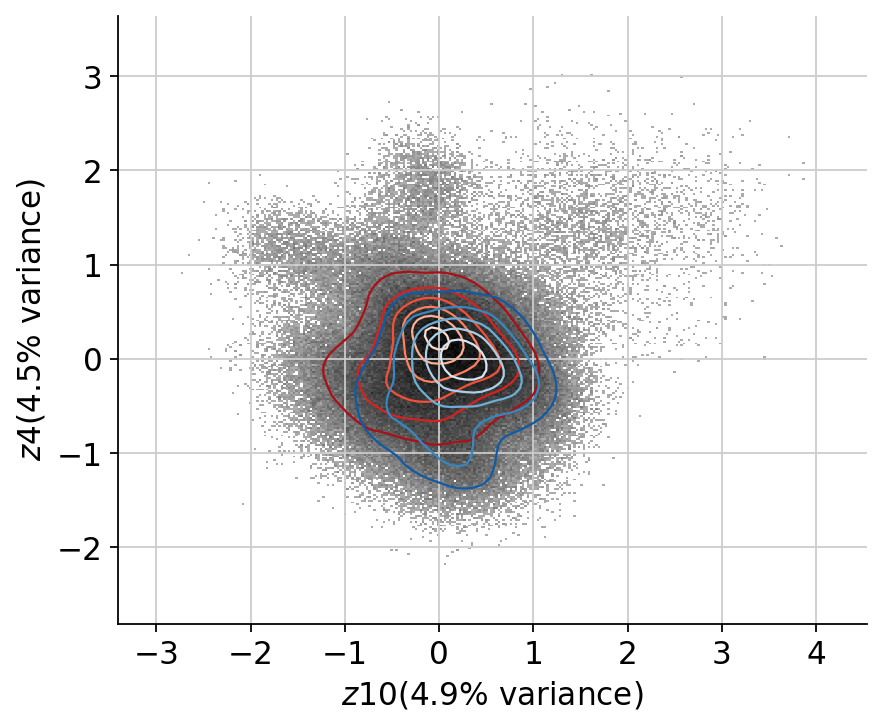

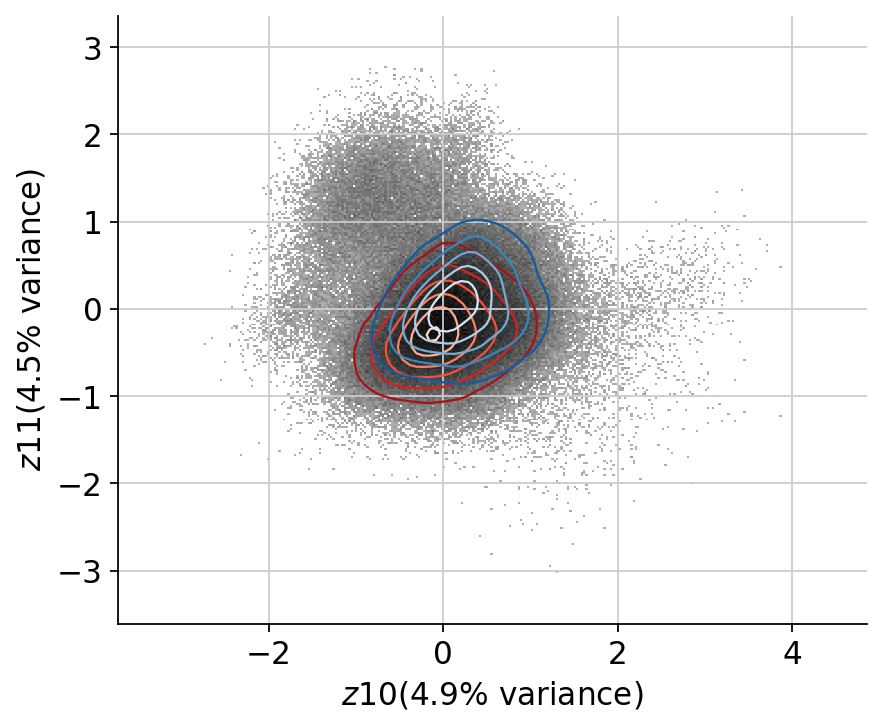

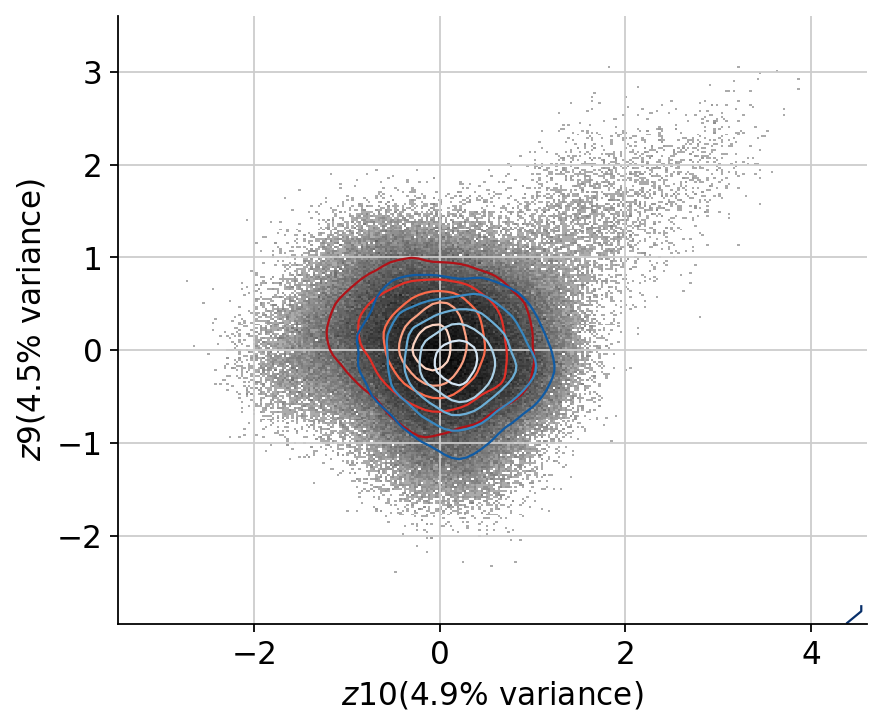

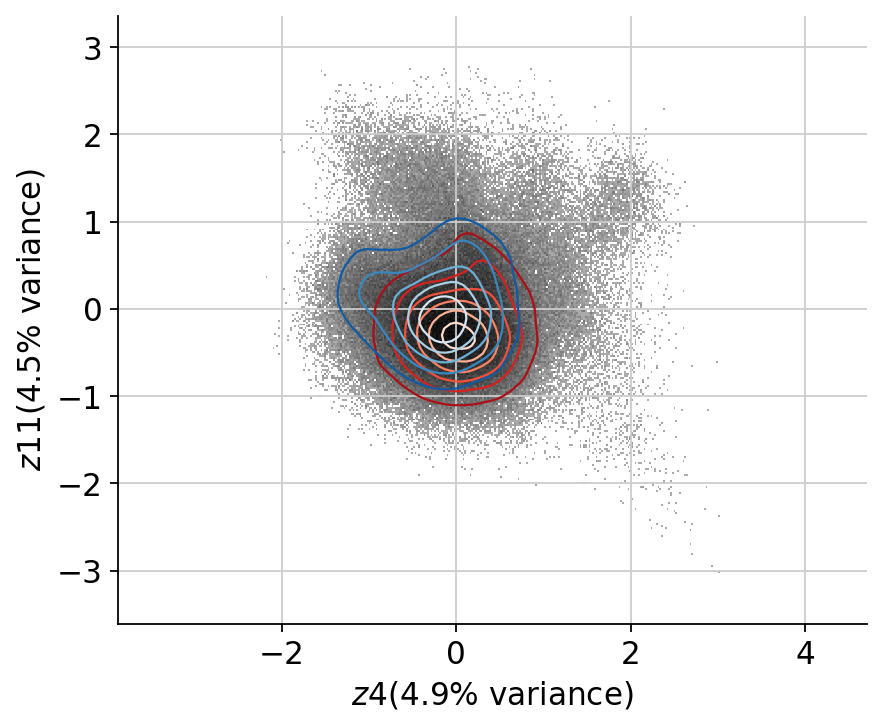

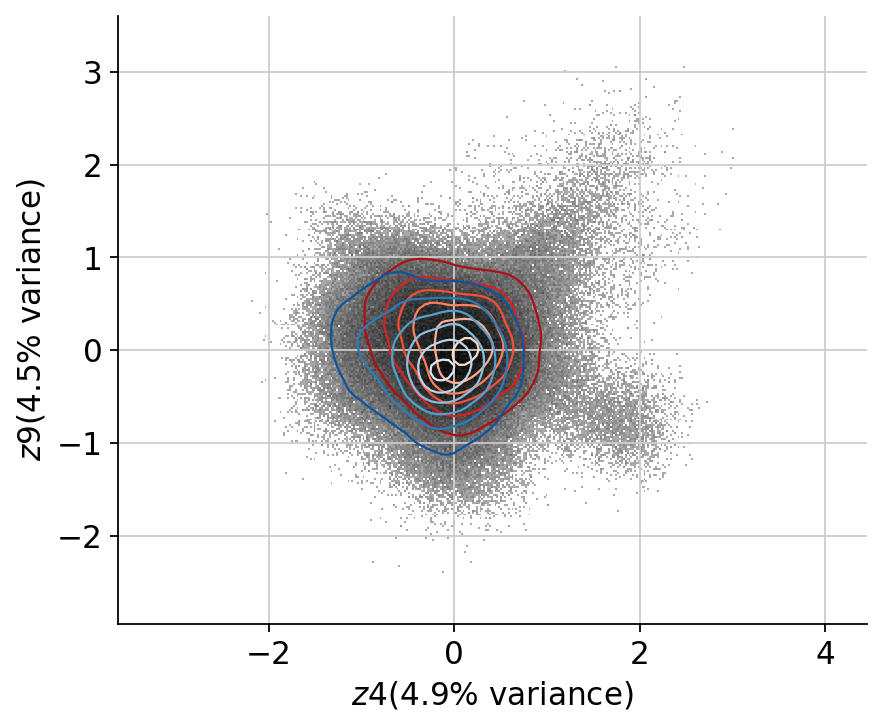

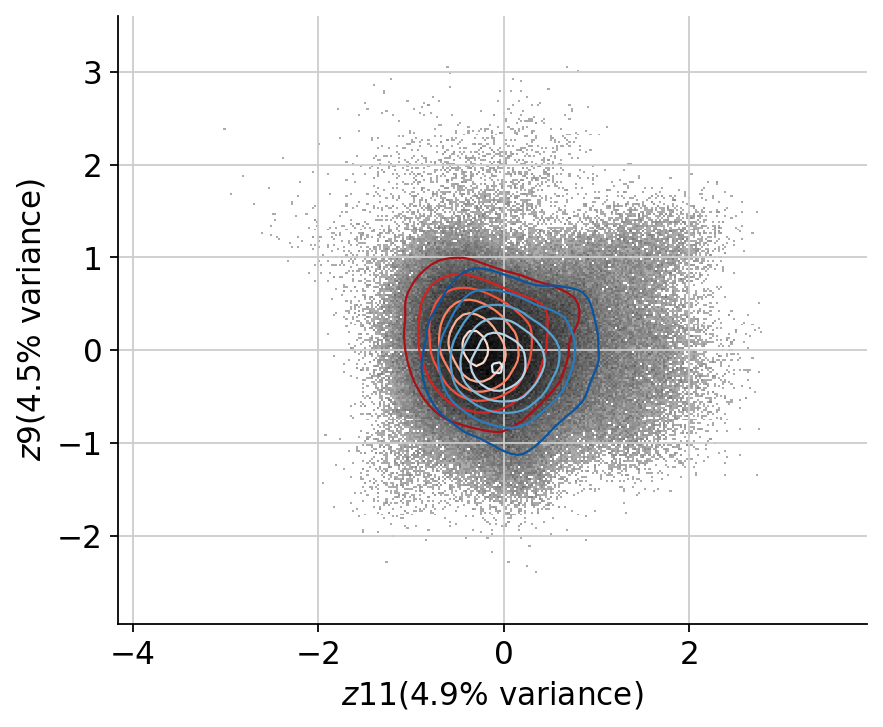

In [ ]:
for (top_factor_1, top_factor_2) in top_factor_pairs:

    plt.figure(figsize=(6, 5)) 

    plt.hist2d(
        Z_df_ordered[top_factor_1], Z_df_ordered[top_factor_2],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )

    plt.axis('equal')
    plt.xlabel(f'${top_factor_1}$' + f'({variance_explained[idx][9]:.1%} variance)')
    plt.ylabel(f'${top_factor_2}$' + f'({variance_explained[idx][12]:.1%} variance)')

    ax = plt.gca()

    color_maps = [cm.Reds_r, cm.Blues_r]
    conditions = ['Alzheimer disease', 'normal']
    for color, ctype in zip(color_maps, conditions):
        X = metadata.query('disease == @ctype')[[top_factor_1, top_factor_2]]
        xx1, xx2, f = make_kde(X[top_factor_1], X[top_factor_2])
        cset = ax.contour(
            xx1,
            xx2,
            f,
            levels=6,
            cmap=color,
            linewidths=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()


# plt.subplot(1, 2, 2)

# plt.scatter(
#     W_df_ordered[weight_dim_1], W_df_ordered['w17'],
#     c='lightgrey',
#     rasterized=True
# )

# arrows = []
# genes = ['Hbb-bs', 'Hbb-bt', 'Hba-a2']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='r'))
    
# plt.text(0, 2, '\n'.join(genes), color='r')

# arrows = []
# genes = ['Pou5f1', 'Tdgf1', 'Snrpn']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='g'))

# plt.text(1, -1.5, '\n'.join(genes), color='g')

# arrows = []
# genes = ['Ctsh', 'Amn', 'Apoa4']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='b'))

# plt.text(-2.6, -0.5, '\n'.join(genes), color='b')


# plt.xlim(left=-3, right=3)
# plt.ylim(bottom=-3, top=3)

# plt.xlabel(f'${weight_dim_1}$')
# plt.ylabel(f'${weight_dim_2}$')

# ax = plt.gca()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig('figures/linear_pij_results_celltypes.pdf', bbox_inches='tight', dpi=400)

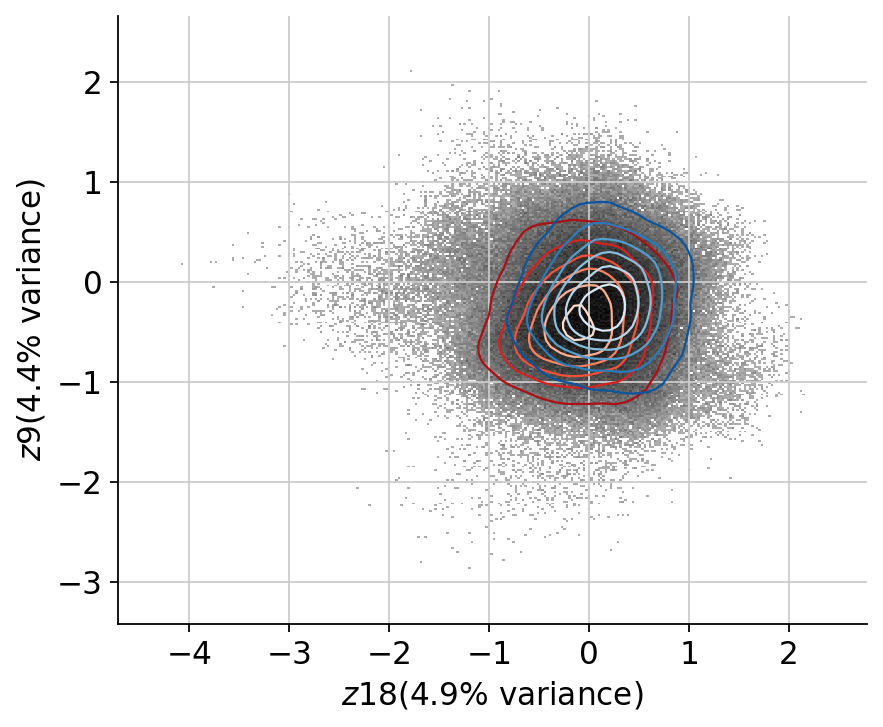

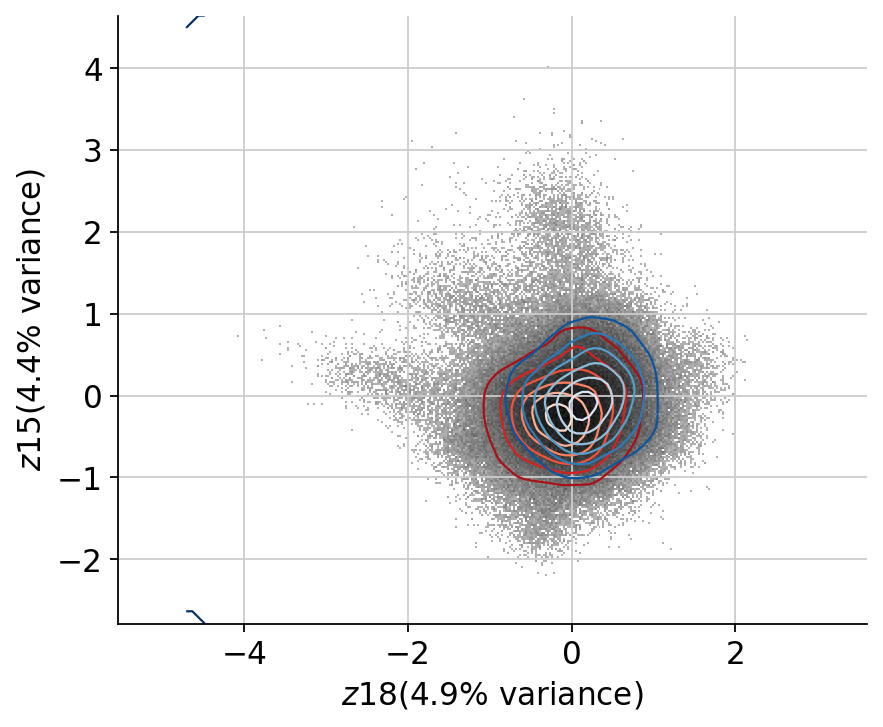

In [ ]:
for (top_factor_1, top_factor_2) in top_factor_pairs:

    plt.figure(figsize=(6, 5)) 

    plt.hist2d(
        Z_df_ordered[top_factor_1], Z_df_ordered[top_factor_2],
        bins=256,
        norm=mcolors.PowerNorm(0.25),
        cmap=cm.gray_r,
        rasterized=True
    )

    plt.axis('equal')
    plt.xlabel(f'${top_factor_1}$' + f'({variance_explained[idx][9]:.1%} variance)')
    plt.ylabel(f'${top_factor_2}$' + f'({variance_explained[idx][12]:.1%} variance)')

    ax = plt.gca()

    color_maps = [cm.Reds_r, cm.Blues_r]
    conditions = ['Alzheimer disease', 'normal']
    for color, ctype in zip(color_maps, conditions):
        X = metadata.query('disease == @ctype')[[top_factor_1, top_factor_2]]
        xx1, xx2, f = make_kde(X[top_factor_1], X[top_factor_2])
        cset = ax.contour(
            xx1,
            xx2,
            f,
            levels=6,
            cmap=color,
            linewidths=1.
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.show()


# plt.subplot(1, 2, 2)

# plt.scatter(
#     W_df_ordered[weight_dim_1], W_df_ordered['w17'],
#     c='lightgrey',
#     rasterized=True
# )

# arrows = []
# genes = ['Hbb-bs', 'Hbb-bt', 'Hba-a2']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='r'))
    
# plt.text(0, 2, '\n'.join(genes), color='r')

# arrows = []
# genes = ['Pou5f1', 'Tdgf1', 'Snrpn']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='g'))

# plt.text(1, -1.5, '\n'.join(genes), color='g')

# arrows = []
# genes = ['Ctsh', 'Amn', 'Apoa4']
# for g in genes:
#     x_, y_ = vardata.query('gene_name == @g')[[weight_dim_1, weight_dim_2]].values[0]

#     arrows.append(plt.arrow(0, 0, x_, y_, length_includes_head=True, color='b'))

# plt.text(-2.6, -0.5, '\n'.join(genes), color='b')


# plt.xlim(left=-3, right=3)
# plt.ylim(bottom=-3, top=3)

# plt.xlabel(f'${weight_dim_1}$')
# plt.ylabel(f'${weight_dim_2}$')

# ax = plt.gca()

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# plt.savefig('figures/linear_pij_results_celltypes.pdf', bbox_inches='tight', dpi=400)

In [ ]:
vardata.sort_values('w12', ascending=False)[['w12', 'gene_name']].head(10)

,w12,gene_name
XIST,0.962941,XIST
DUSP1,0.873586,DUSP1
ADAMTS18,0.848449,ADAMTS18
GADD45B,0.815138,GADD45B
NEAT1,0.805007,NEAT1
S100A6,0.787306,S100A6
JUNB,0.755395,JUNB
SRGN,0.738422,SRGN
ZFP36,0.728525,ZFP36
FN1,0.705459,FN1


In [ ]:
vardata.sort_values('w11', ascending=False)[['w11', 'gene_name']].head(10)

,w11,gene_name
CNDP1,1.471846,CNDP1
SLC5A11,1.104080,SLC5A11
CHI3L1,0.927205,CHI3L1
NPTX1,0.903622,NPTX1
UNC13C,0.878497,UNC13C
SLIT2,0.860277,SLIT2
BCYRN1,0.822129,BCYRN1
CELF4,0.762760,CELF4
CD163,0.753112,CD163
S100A6,0.739377,S100A6


In [ ]:
vardata.sort_values('w18', ascending=False)[['w18', 'gene_name']].tail(10)

,w18,gene_name
SLC1A3,-0.560704,SLC1A3
PDK4,-0.598888,PDK4
WDR49,-0.606264,WDR49
PDGFD,-0.616787,PDGFD
TENM3,-0.627074,TENM3
AC002429.5,-0.637880,AC002429.5
TNC,-0.645860,TNC
TNIK,-0.706574,TNIK
ERBB4,-0.741648,ERBB4
LINC01099,-1.308733,LINC01099
